데이터 출처: <a href = 'https://www.kaggle.com/c/word2vec-nlp-tutorial' > 캐글 - Bag of Words Meets Bags of Popcorn</a>

# NLP 란?

NLP(Natural Language Processing) 은 문자 문제를 다루는 테크닉이다.  
이번 파트에서는 `Bag of Words Model`로 IMDB movie review를 분석해서 긍정 리뷰인지, 부정 리뷰인지 예측해본다.


# Data load

In [84]:
import pandas as pd
"""
header = 0 은 파일의 첫 번째 줄에 열 이름이 있음을 나타냄
delimiter = \t은 필드가 탭으로 구분 되는 것을 나타냄
quoter = 3은 쌍따옴표 무시
"""

train = pd.read_csv('data/labeledTrainData.tsv', header = 0, delimiter = '\t' )
test = pd.read_csv('data/testData.tsv' , header= 0,delimiter = '\t')

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         25000 non-null  object
 1   sentiment  25000 non-null  int64 
 2   review     25000 non-null  object
dtypes: int64(1), object(2)
memory usage: 586.1+ KB


In [31]:
train.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [32]:
train.shape

(25000, 3)

In [33]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      25000 non-null  object
 1   review  25000 non-null  object
dtypes: object(2)
memory usage: 390.8+ KB


In [34]:
test.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of ..."
1,"""8348_2""","""This movie is a disaster within a disaster fi..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw ..."
3,"""7186_2""","""Afraid of the Dark left me with the impressio..."
4,"""12128_7""","""A very accurate depiction of small time mob l..."


In [35]:
test.shape

(25000, 2)

# Preprocessing

신호와 소음을 구분한다.
아웃라이어데이터로 인한 오버피팅 방지한다.

1. BeautifulSoup 으로 HTML 태그 제거
1. 정규표현식으로 알파벳 이외의 문자를 공백으로 치환
2. NLTK 데이터를 사용해 불용어(Stopword)를 제거
3. 어간추출 (Stemming)과 음소표기법(Lemmatizing)의 개념을 이해하고 SnowballStemmer를 통해 어간을 추출


한국어 전처리 (KoNLPy) <a href='https://github.com/twitter/twitter-korean-text'> 깃허브 코드</a>

## HTML 제거

In [85]:
from bs4 import BeautifulSoup as bs

ex = bs(train['review'][0],'html5lib')
ex.get_text()

"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.The actual feature film bit when it finally starts is only on for 20 mi

## 정규표현식으로 특수문자 제거

In [86]:
import re

# 소문자와 대문자가 아닌 것은 공백으로 대체한다.
letters_only = re.sub('[^a-zA-Z]', ' ', ex.get_text())
letters_only[:1000]

'With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring  Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him The actual feature film bit when it finally starts is only on for    mi

In [87]:
# 모두 소문자로 변환
lower_case = letters_only.lower()

# 문자를 나눈다 -> 토큰화
words = lower_case.split()
print(words[:10])
print('단어 수: ',len(words))

['with', 'all', 'this', 'stuff', 'going', 'down', 'at', 'the', 'moment', 'with']
단어 수:  437


## 불용어 제거 (Stopword Removal)

예측 프로세스에 실제로 기여하지 않지만 자주 나타나는 i, me, my , it, that ,is 등 과 같은 단어와 stopwords는 'to' 또는 'the' 같은 용어를 포함하므로 사전 처리 단계에서 제거하는 것이 좋다. NLTK 에는 153개의 영어 불용어가 미리 정의 되어 있다. (한국어는 없다 ㅠ)

In [88]:
import nltk
from nltk.corpus import stopwords

In [89]:
# 미리 정의된 불용어 확인
stopwords.words('english')[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [90]:
# stopwords 제거한 토큰
words = [w for w in words if not w in stopwords.words('english')]

In [91]:
print('불용어 제거한 단어수:',len(words))

불용어 제거한 단어수: 219


In [92]:
words[:10]

['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

## 스테밍(어간추출, 형태소 분석)

단어에서 어간을 추출해서, 단어의 종류를 줄일 수 있다.  

1) 어간(stem)
: 단어의 의미를 담고 있는 단어의 핵심 부분.

2) 접사(affix)
: 단어에 추가적인 의미를 주는 부분.

예를들어 massage, mssages, messaging 에서 massage를 어간이라고하며,뒤에 붙는 s, ing등을 접사라고 할 수 있다. 여기서 어간인 massage로 통일하면 분석에 필요한 단어 수를 줄일 수 있다. (같은 의미이나 다른 형태로 쓰여진 단어들)

- 포터 형태소 분석기: 보수적
- 랭커스터 형태소 분석기: 좀 더 적극적 -> 더 많은 동음이의어 형태소 생산


In [78]:
# 포터스태머 사용 예
stemmer = nltk.stem.PorterStemmer()
print(stemmer.stem('maximum'))
print('running: ',stemmer.stem('running'))
print('runs: ',stemmer.stem('runs'))
print('run: ',stemmer.stem('run'))

maximum
running:  run
runs:  run
run:  run


In [77]:
# 랭커스터 스태머 사용 예
from nltk.stem.lancaster import LancasterStemmer
lancaster_stemmer = LancasterStemmer()

print(lancaster_stemmer.stem('maximum'))
print('running: ',lancaster_stemmer.stem('running'))
print('runs: ',lancaster_stemmer.stem('runs'))
print('run: ',lancaster_stemmer.stem('run'))

maxim
running:  run
runs:  run
run:  run


In [79]:
# 스태밍 전 단어
words[:20]

['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary',
 'watched',
 'wiz',
 'watched',
 'moonwalker',
 'maybe',
 'want',
 'get',
 'certain',
 'insight',
 'guy']

In [94]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer('english')
words_stem = [stemmer.stem(w) for w in words]

# 스테밍 후 단어
words_stem

['stuff',
 'go',
 'moment',
 'mj',
 'start',
 'listen',
 'music',
 'watch',
 'odd',
 'documentari',
 'watch',
 'wiz',
 'watch',
 'moonwalk',
 'mayb',
 'want',
 'get',
 'certain',
 'insight',
 'guy',
 'thought',
 'realli',
 'cool',
 'eighti',
 'mayb',
 'make',
 'mind',
 'whether',
 'guilti',
 'innoc',
 'moonwalk',
 'part',
 'biographi',
 'part',
 'featur',
 'film',
 'rememb',
 'go',
 'see',
 'cinema',
 'origin',
 'releas',
 'subtl',
 'messag',
 'mj',
 'feel',
 'toward',
 'press',
 'also',
 'obvious',
 'messag',
 'drug',
 'bad',
 'kay',
 'visual',
 'impress',
 'cours',
 'michael',
 'jackson',
 'unless',
 'remot',
 'like',
 'mj',
 'anyway',
 'go',
 'hate',
 'find',
 'bore',
 'may',
 'call',
 'mj',
 'egotist',
 'consent',
 'make',
 'movi',
 'mj',
 'fan',
 'would',
 'say',
 'made',
 'fan',
 'true',
 'realli',
 'nice',
 'actual',
 'featur',
 'film',
 'bit',
 'final',
 'start',
 'minut',
 'exclud',
 'smooth',
 'crimin',
 'sequenc',
 'joe',
 'pesci',
 'convinc',
 'psychopath',
 'power',
 'drug

## Lemmatization 음소표기법

동음이의어가 문맥에 따라 다른 의미를 가질 때, 앞뒤 문맥을 보고 단어의 의미를 식별하는 것

배: 먹는 배, 타는 배, 몸에 속하는 배 인지를 문맥에 따라 추출

In [95]:
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

words_lemmatize = [wordnet_lemmatizer.lemmatize(w) for w in words]
words_lemmatize

['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary',
 'watched',
 'wiz',
 'watched',
 'moonwalker',
 'maybe',
 'want',
 'get',
 'certain',
 'insight',
 'guy',
 'thought',
 'really',
 'cool',
 'eighty',
 'maybe',
 'make',
 'mind',
 'whether',
 'guilty',
 'innocent',
 'moonwalker',
 'part',
 'biography',
 'part',
 'feature',
 'film',
 'remember',
 'going',
 'see',
 'cinema',
 'originally',
 'released',
 'subtle',
 'message',
 'mj',
 'feeling',
 'towards',
 'press',
 'also',
 'obvious',
 'message',
 'drug',
 'bad',
 'kay',
 'visually',
 'impressive',
 'course',
 'michael',
 'jackson',
 'unless',
 'remotely',
 'like',
 'mj',
 'anyway',
 'going',
 'hate',
 'find',
 'boring',
 'may',
 'call',
 'mj',
 'egotist',
 'consenting',
 'making',
 'movie',
 'mj',
 'fan',
 'would',
 'say',
 'made',
 'fan',
 'true',
 'really',
 'nice',
 'actual',
 'feature',
 'film',
 'bit',
 'finally',
 'start',
 'minute',
 'excluding',
 'smooth',
 'criminal',
 

In [98]:
df = pd.DataFrame({
    'stem' : words_stem,
    'lemma': words_lemmatize
})
df.head()

,stem,lemma
0,stuff,stuff
1,go,going
2,moment,moment
3,mj,mj
4,start,started


In [102]:
# stem과 lemma에서 다르게 분류된 단어 약 80
df[df['stem'] != df['lemma']].head(50)

,stem,lemma
1,go,going
4,start,started
5,listen,listening
7,watch,watching
9,documentari,documentary
10,watch,watched
12,watch,watched
13,moonwalk,moonwalker
14,mayb,maybe
21,realli,really


## 전처리 함수

In [105]:
def review_to_word(raw_review):
    #1. html 제거
    review_text = bs(raw_review, 'html.parser').get_text()
    
    #2. 영문자가 아닌 문자 공백으로 변환
    letters_only =  re.sub('[^a-zA-Z]',' ',review_text)
    
    #3. 소문자 변환
    words = letters_only.lower().split()
    
    #4. stopwords
    stops = set(stopwords.words('english'))
    meaningful_words = [w for w in words if not w in stops]
    
    #5. 어간 추출
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    
    #6. 공백으로 구분된 문자열로 결합하여 결과를 반환
    return (' '.join(stemming_words))

## 전처리 과정 전체 review에 적용하기

약 3분소요


In [106]:
train['review_clean']=train['review'].apply(review_to_word)

In [107]:
test['review_clean'] = test['review'].apply(review_to_word)

# 시각화: 워드클라우드

- 단어의 빈도 수 데이터를 가지고 있을 때 이용할 수 있는 시각화 방법
- 단순히 빈도 수를 표현하기 보다는 상관관계나 유사도 등으로 배치하는게 더 의미 있기 때문에 큰 정보를 얻기는 어려움

In [114]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def displayWordCloud(data=None, backgroundcolor = 'white', width= 800, height =500):
    wordcloud = WordCloud(stopwords = STOPWORDS,
                         background_color=backgroundcolor,
                         width= width,
                         height = height).generate(data)
    plt.figure(figsize = (15,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [123]:
train_clean_review = []
test_clean_review = []
for i in train['review_clean']:
    train_clean_review.append(i)
    
for i in test['review_clean']:
    test_clean_review.append(i)

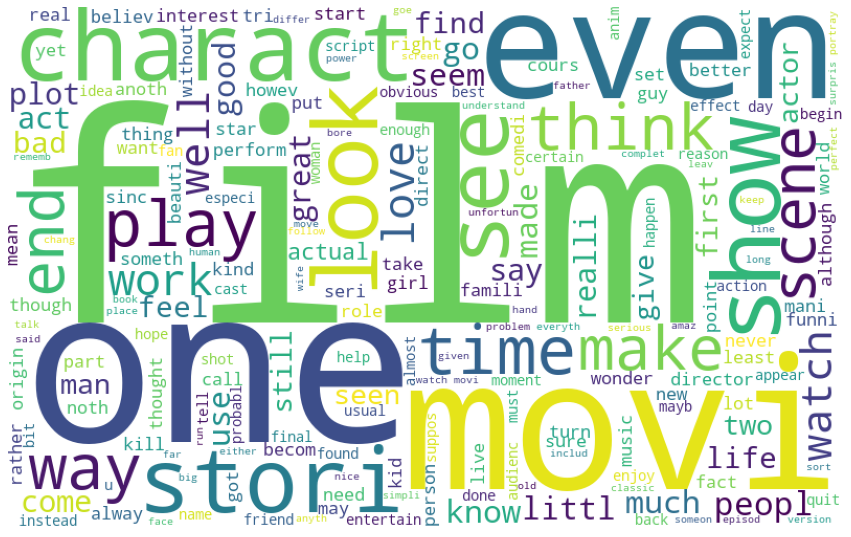

In [122]:
displayWordCloud(' '.join(train_clean_review))

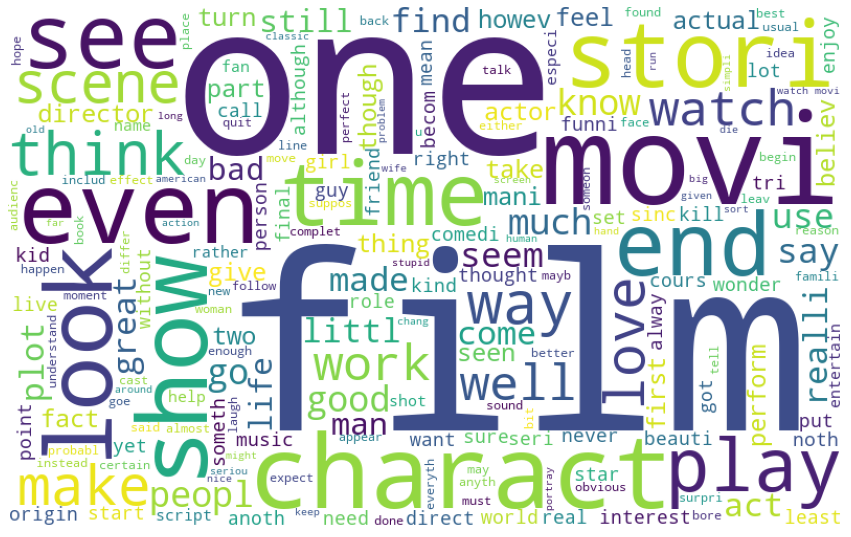

In [124]:
displayWordCloud(' '.join(test_clean_review))

# 단어 갯수 분포

In [134]:
# 각 리뷰에 단어갯수 (중복 제거하지 않음)
train['word_count']=train['review_clean'].apply(lambda x: len(str(x).split()))
test['word_count']=test['review_clean'].apply(lambda x: len(str(x).split()))

# 각 리뷰에 단어갯수 (중복 제거)
train['word_count_unique']=train['review_clean'].apply(lambda x: len(set(str(x).split())))
test['word_count_unique']=test['review_clean'].apply(lambda x: len(set(str(x).split())))

리뷰별 단어 평균 값: 119.52356
리뷰별 단어 중간 값: 89.0
리뷰별 고유 단어 평균 값: 94.05756
리뷰별 고유 단어 중간 값: 74.0


Text(0.5, 1.0, '리뷰별 고유 단어 수 분포')

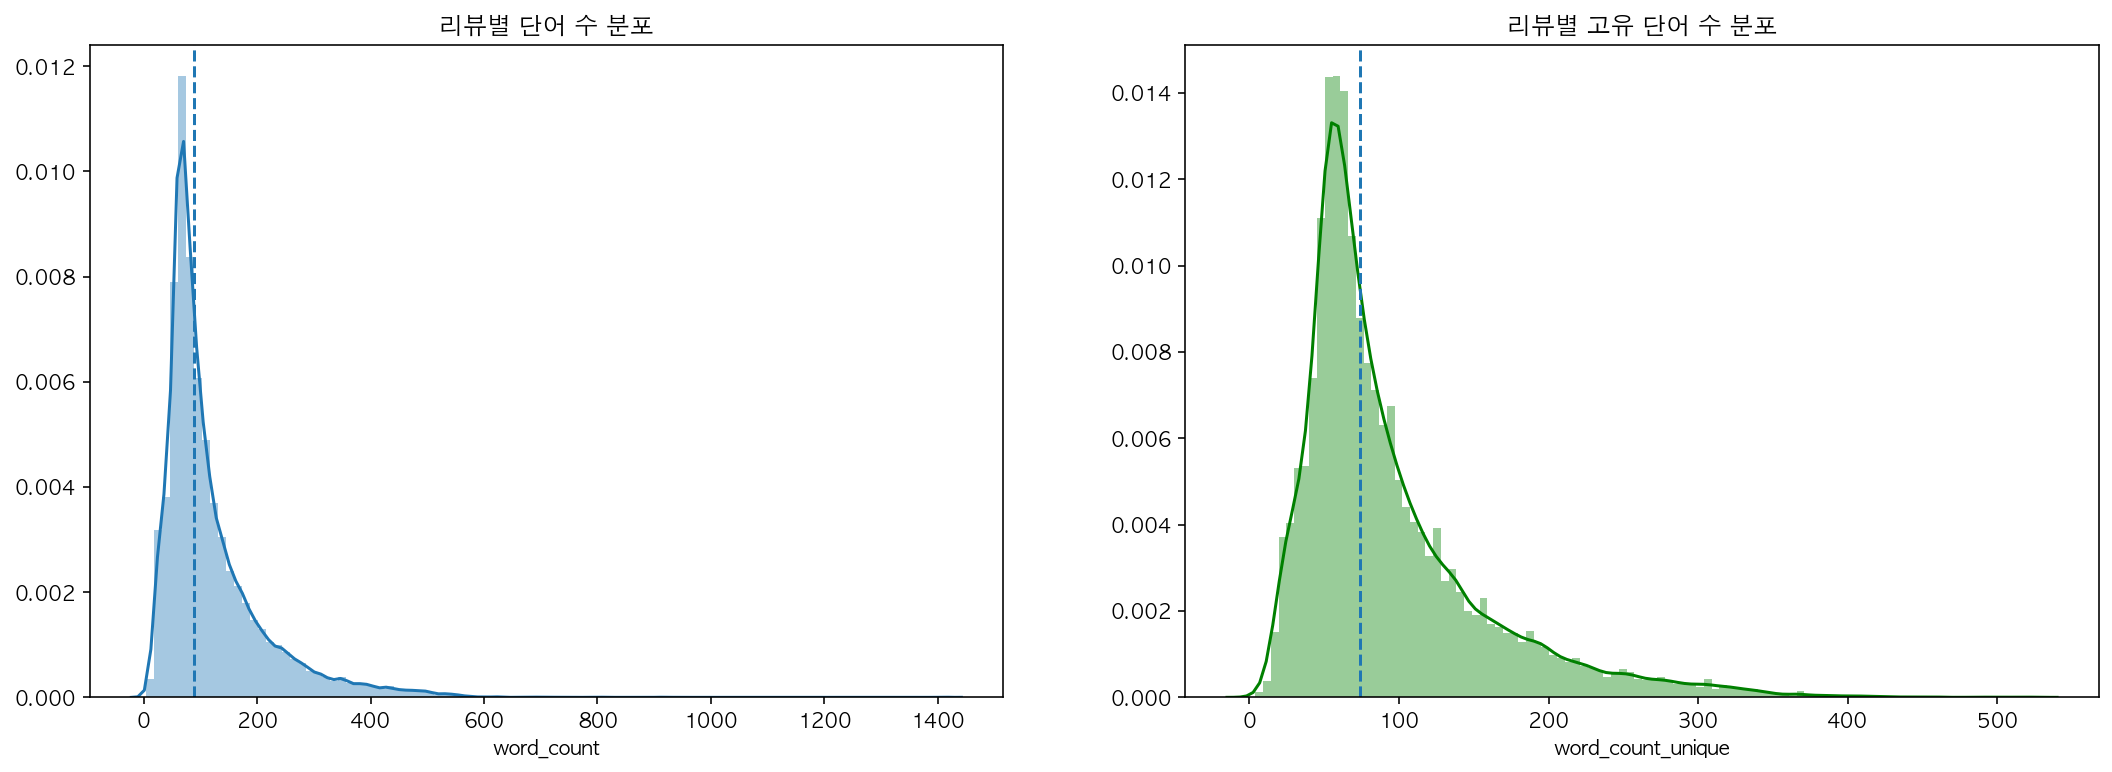

In [152]:
import seaborn as sns
plt.rc('font',family='AppleGothic')
plt.rc('axes', unicode_minus=False)

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

%matplotlib inline

fig, axes = plt.subplots(ncols=2)
fig.set_size_inches(18,6)
print('리뷰별 단어 평균 값:', train['word_count'].mean())
print('리뷰별 단어 중간 값:', train['word_count'].median())

sns.distplot(train['word_count'],bins=100, ax=axes[0])
axes[0].axvline(train['word_count'].median(),linestyle='dashed')
axes[0].set_title('리뷰별 단어 수 분포')

print('리뷰별 고유 단어 평균 값:', train['word_count_unique'].mean())
print('리뷰별 고유 단어 중간 값:', train['word_count_unique'].median())

sns.distplot(train['word_count_unique'],bins=100, ax=axes[1], color='g')
axes[1].axvline(train['word_count_unique'].median(),linestyle='dashed')
axes[1].set_title('리뷰별 고유 단어 수 분포')

# Bag-of-words model 

CounterVectorizer로 텍스트 데이터 벡터화  
문장에서 유니크 값들만 뽑아서 각 문장에 해당 단어가 몇회 들어가 있는지 벡터화한다.

<a href='https://en.wikipedia.org/wiki/Bag-of-words_model'> 위키피디아 예시</a>

1) John likes to watch movies. Mary likes movies too.  
2) Mary also likes to watch football games.

-> 두 문장에서 unique한 단어만 추출
['John','likes','to','watch','movies','Mary','too','also','football','games'] 

1) [1,2,1,1,2,1,1,0,0,0]  
2) [0,1,1,1,0,1,0,1,1,1]


## 사이킷런의 CounterVectorizer를 통해 피처 생성

- 정규표현식을 사용해 토큰을 추출한다.
- 모두 소문자로 변환시키기 때문에, good, Good, goOd이 모두 같은 특성이 된다.
- 의미없는 특성을 많이 생성하기 때문에 적어도 두 개의 문서에 나타난 토큰만을 사용한다.
- min_df로 토큰이 나타날 최소 문서 개수를 지정할 수 있다.

In [155]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

In [157]:
vectorizer = CountVectorizer(analyzer='word',
                             tokenizer= None,
                             preprocessor= None,
                             stop_words = None,
                             min_df =2,
                             ngram_range=(1,3), 
                             max_features = 20000
    
)
vectorizer

CountVectorizer(max_features=20000, min_df=2, ngram_range=(1, 3))

In [158]:
pipeline = Pipeline([
    ('vect',vectorizer),
])

In [185]:
train_features = pipeline.fit_transform(train['review_clean'])

In [162]:
train_features.shape

(25000, 20000)

In [186]:
test_features = pipeline.fit_transform(test['review_clean'])

In [166]:
vocab = vectorizer.get_feature_names()
vocab[:10]

['aag',
 'aaron',
 'ab',
 'abandon',
 'abbey',
 'abbi',
 'abbot',
 'abbott',
 'abc',
 'abduct']

In [168]:
import numpy as np
dist = np.sum(train_features, axis = 0)

# 전체 단어 갯수 합
pd.DataFrame(dist, columns=vocab)

aag [[26 48 22 ... 59 40 23]]


,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,...,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,26,48,22,288,24,30,29,30,125,55,...,23,52,37,89,161,31,71,59,40,23


In [170]:
# 각 행에서 단어 갯수
pd.DataFrame(train_features.toarray(),columns=vocab).head(20)

,aag,aaron,ab,abandon,abbey,abbi,abbot,abbott,abc,abduct,...,zombi bloodbath,zombi film,zombi flick,zombi movi,zone,zoo,zoom,zorro,zu,zucker
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Randomforest 로 영화 감성 예측 평가

In [182]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier( n_estimators = 100
                                  , n_jobs= -1
                                  , random_state = 1111
)
forest

RandomForestClassifier(n_jobs=-1, random_state=1111)

In [187]:
forest.fit(train_features, train['sentiment'])

RandomForestClassifier(n_jobs=-1, random_state=1111)

In [188]:
from sklearn.model_selection import cross_val_score

score = np.mean(cross_val_score(
    forest
    , train_features
    ,train['sentiment']
    ,cv = 10
    ,scoring ='roc_auc'
))

KeyboardInterrupt: 

In [189]:
result=forest.predict(test_features)

In [190]:
output = pd.DataFrame(data={'id':test['id'],'sentiment':result})
output.head()

,id,sentiment
0,12311_10,0
1,8348_2,0
2,5828_4,0
3,7186_2,1
4,12128_7,1


In [191]:
output.to_csv('data/tuto1.csv' , index=False)